In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

In [3]:
# Reduce Memory Usage
# reference : https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65 @ARJANGROEN

def reduce_memory_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage became: ",mem_usg," MB")
    
    return df

In [4]:
train = pd.read_csv("/kaggle/input/predict-student-performance-from-game-play/train.csv")
train.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [5]:
train = reduce_memory_usage(train)
train.info()

Memory usage of dataframe is 2010.23 MB
Memory usage became:  778.9939136505127  MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13174211 entries, 0 to 13174210
Data columns (total 20 columns):
 #   Column          Dtype   
---  ------          -----   
 0   session_id      int64   
 1   index           int16   
 2   elapsed_time    int32   
 3   event_name      category
 4   name            category
 5   level           int8    
 6   page            float16 
 7   room_coor_x     float16 
 8   room_coor_y     float16 
 9   screen_coor_x   float16 
 10  screen_coor_y   float16 
 11  hover_duration  float32 
 12  text            category
 13  fqid            category
 14  room_fqid       category
 15  text_fqid       category
 16  fullscreen      float64 
 17  hq              float64 
 18  music           float64 
 19  level_group     category
dtypes: category(7), float16(5), float32(1), float64(3), int16(1), int32(1), int64(1), int8(1)
memory usage: 779.0 MB


In [6]:
train.shape

(13174211, 20)

In [7]:
import gc
gc.collect()

81

In [8]:
target = pd.read_csv("/kaggle/input/predict-student-performance-from-game-play/train_labels.csv")
target.head()

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1
3,20090314363702160_q1,1
4,20090314441803444_q1,1


In [9]:
target['session'] = target.session_id.apply(lambda x: int(x.split('_')[0]) )
target['q'] = target.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
print( target.shape )
target.head()

(212022, 4)


,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090314121766812_q1,1,20090314121766812,1
3,20090314363702160_q1,1,20090314363702160,1
4,20090314441803444_q1,1,20090314441803444,1


In [10]:
gc.collect()

63

In [11]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values * 100
    summ['%missing'] = df.isnull().sum().values / len(df)
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [12]:
summary_table = summary(train)
summary_table

data shape: (13174211, 20)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
session_id,int64,0,0.000000,11779,20090312431273200.0,22100221145014656.0,20090312431273200,20090312431273200,20090312431273200
index,int16,0,0.000000,20348,0.0,20473.0,0,1,2
elapsed_time,int32,0,0.000000,3804019,0.0,1749293395.0,0,1323,831
event_name,category,0,0.000000,11,NaN,NaN,cutscene_click,person_click,person_click
name,category,0,0.000000,6,NaN,NaN,basic,basic,basic
level,int8,0,0.000000,23,0.0,22.0,0,0,0
page,float16,1288946500,0.978386,7,0.0,6.0,NaN,NaN,NaN
room_coor_x,float16,103624000,0.078657,28082,-1992.0,1262.0,-414.0,-414.0,-414.0
room_coor_y,float16,103624000,0.078657,25809,-918.0,543.5,-159.375,-159.375,-159.375
screen_coor_x,float16,103624000,0.078657,6266,0.0,1916.0,380.0,380.0,380.0


Feature Engineering

In [13]:
CATS = ['event_name', 'fqid', 'room_fqid', 'text']
NUMS = ['elapsed_time','level','page','room_coor_x', 'room_coor_y','screen_coor_x', 'screen_coor_y', 'hover_duration']


In [14]:
#create dummies
just_dummies = pd.get_dummies(train['event_name'])

train = pd.concat([train, just_dummies], axis=1)

In [15]:
# I comment this code because of the RAM issue
# train.head()

In [16]:
train['event_name'].value_counts()

navigate_click        5687896
person_click          3024847
cutscene_click        1351732
object_click          1099670
object_hover           529116
map_hover              471621
notification_click     324106
notebook_click         284746
map_click              258714
observation_click      106260
checkpoint              35503
Name: event_name, dtype: int64

In [17]:
# https://www.kaggle.com/code/kimtaehun/lightgbm-baseline-with-aggregated-log-data
EVENTS = ['navigate_click','person_click','cutscene_click','object_click',
          'map_hover','notification_click','map_click','observation_click',
          'checkpoint']

In [18]:
def feature_engineer(train):
    
    dfs = []
    for c in CATS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    for c in EVENTS: 
        train[c] = (train.event_name == c).astype('int8')
    for c in EVENTS + ['elapsed_time']:
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    train = train.drop(EVENTS,axis=1)
        
    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [19]:
%%time
df = feature_engineer(train)
print( df.shape )
df.head()

(35337, 31)
CPU times: user 20.8 s, sys: 3.31 s, total: 24.1 s
Wall time: 24.1 s


,level_group,event_name_nunique,fqid_nunique,room_fqid_nunique,text_nunique,elapsed_time_mean,level_mean,page_mean,room_coor_x_mean,room_coor_y_mean,...,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,map_hover_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum,elapsed_time_sum
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,30,7,56,8.579356e+04,1.945455,-1.000000,7.687500,-71.43750,...,81.0,22.0,28.0,11.0,4.0,8,2.0,4,1,1.415594e+07
20090312431273200,13-22,10,49,12,168,1.040601e+06,17.402381,-1.000000,-130.375000,-162.00000,...,170.0,123.0,60.0,20.0,14.0,10,6.0,3,1,4.370523e+08
20090312431273200,5-12,10,39,11,124,3.572052e+05,8.054054,-1.000000,14.304688,-57.28125,...,103.0,104.0,12.0,28.0,9.0,9,8.0,1,1,1.057327e+08
20090312433251036,0-4,11,22,6,49,9.763342e+04,1.870504,0.000000,-84.062500,-53.65625,...,49.0,18.0,36.0,15.0,3.0,5,3.0,2,1,1.357104e+07
20090312433251036,13-22,11,73,16,183,2.498852e+06,17.762529,5.101562,-30.750000,-142.87500,...,637.0,145.0,65.0,83.0,186.0,14,45.0,5,1,3.241011e+09


In [20]:
gc.collect()

21

In [21]:
#check data type
df.dtypes

level_group               category
event_name_nunique           int64
fqid_nunique                 int64
room_fqid_nunique            int64
text_nunique                 int64
elapsed_time_mean          float64
level_mean                 float64
page_mean                  float16
room_coor_x_mean           float16
room_coor_y_mean           float16
screen_coor_x_mean         float16
screen_coor_y_mean         float16
hover_duration_mean        float32
elapsed_time_std           float64
level_std                  float64
page_std                   float64
room_coor_x_std            float64
room_coor_y_std            float64
screen_coor_x_std          float64
screen_coor_y_std          float64
hover_duration_std         float64
navigate_click_sum         float64
person_click_sum           float64
cutscene_click_sum         float64
object_click_sum           float64
map_hover_sum              float64
notification_click_sum        int8
map_click_sum              float64
observation_click_su

In [22]:
FEATURES = [c for c in df.columns if c != 'level_group']
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = df.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 30 features
We will train with 11779 users info


Train XGBoost Model

In [23]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    xgb_params = {
    'objective' : 'binary:logistic',
    'eval_metric':'logloss',
    'learning_rate': 0.05,
    'max_depth': 4,
    'n_estimators': 1000,
    'early_stopping_rounds': 50,
    'tree_method':'hist',
    'subsample':0.8,
    'colsample_bytree': 0.4,
    'use_label_encoder' : False}
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = target.loc[target.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = target.loc[target.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[ (valid_x[FEATURES].astype('float32'), valid_y['correct']) ],
                verbose=0)
        print(f'{t}({clf.best_ntree_limit}), ',end='')
        
        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()

#########################
### Fold 1
#########################
1(144), 2(129), 3(100), 4(210), 5(90), 6(161), 7(168), 8(69), 9(114), 10(161), 11(169), 12(95), 13(151), 14(100), 15(234), 16(102), 17(76), 18(157), 
#########################
### Fold 2
#########################
1(177), 2(115), 3(205), 4(110), 5(78), 6(119), 7(169), 8(46), 9(118), 10(109), 11(70), 12(67), 13(75), 14(171), 15(111), 16(68), 17(41), 18(103), 
#########################
### Fold 3
#########################
1(65), 2(137), 3(101), 4(91), 5(68), 6(77), 7(78), 8(49), 9(174), 10(61), 11(79), 12(75), 13(118), 14(150), 15(194), 16(93), 17(90), 18(131), 
#########################
### Fold 4
#########################
1(197), 2(109), 3(97), 4(130), 5(113), 6(84), 7(121), 8(36), 9(67), 10(84), 11(90), 12(90), 13(82), 14(119), 15(124), 16(56), 17(70), 18(163), 
#########################
### Fold 5
#########################
1(162), 2(133), 3(87), 4(69), 5(58), 6(116), 7(107), 8(55), 9(150), 10(75), 11(74), 12(93), 13(80), 1

In [24]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = target.loc[target.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [25]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

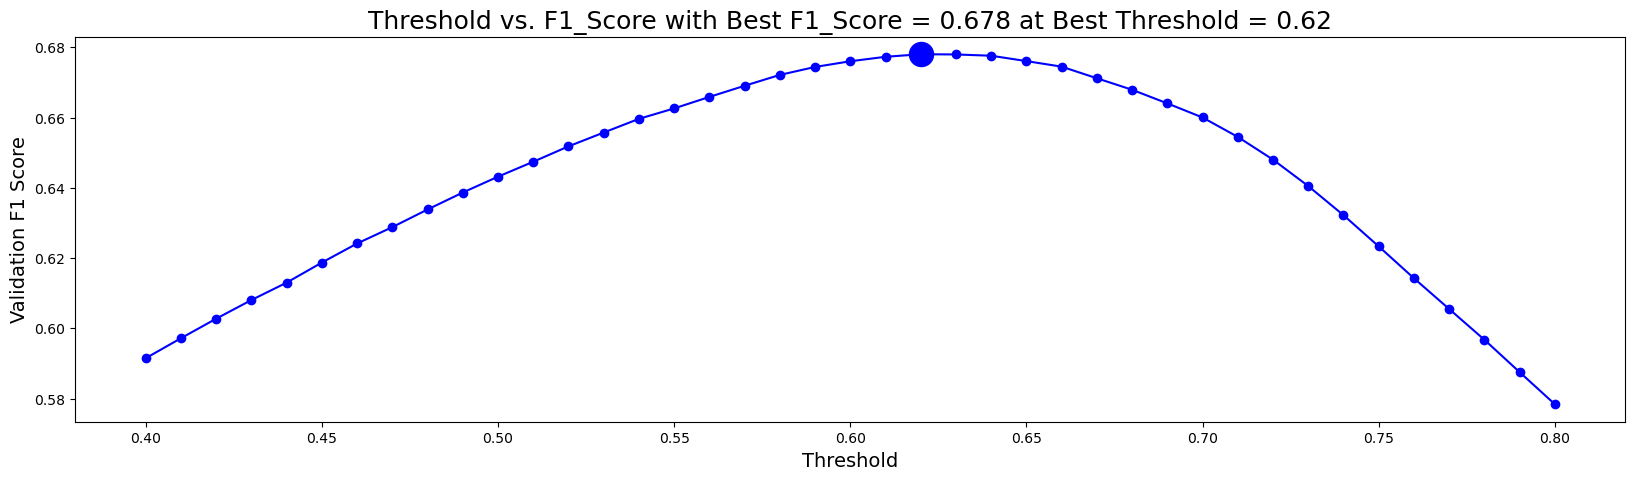

In [26]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [27]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.5890601055958569
Q1: F1 = 0.4945936668669012
Q2: F1 = 0.4897081796084226
Q3: F1 = 0.6079912358514885
Q4: F1 = 0.5739871003332117
Q5: F1 = 0.60643555964107
Q6: F1 = 0.5866937112737562
Q7: F1 = 0.537124911124852
Q8: F1 = 0.6001710676325901
Q9: F1 = 0.5102005280011247
Q10: F1 = 0.5950573282945046
Q11: F1 = 0.4992582579752273
Q12: F1 = 0.4336044423365807
Q13: F1 = 0.6030546532006967
Q14: F1 = 0.5196048370849733
Q15: F1 = 0.4487225111143779
Q16: F1 = 0.5331811952051545
Q17: F1 = 0.49387407107981585
==> Overall F1 = 0.6780423163428528


Infer Test Data

In [28]:
# IMPORT KAGGLE API
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

In [29]:
# CLEAR MEMORY
import gc
del train, target, df, oof, true
_ = gc.collect()

In [30]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for (sample_submission, test) in iter_test:
    
    # FEATURE ENGINEER TEST DATA
    df = feature_engineer(test)
    
    # INFER TEST DATA
    grp = test.level_group.values[0]
    a,b = limits[grp]
    for t in range(a,b):
        clf = models[f'{grp}_{t}']
        p = clf.predict_proba(df[FEATURES].astype('float32'))[:,1]
        mask = sample_submission.session_id.str.contains(f'q{t}')
        sample_submission.loc[mask,'correct'] = int(p.item()>best_threshold)
    
    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


EDA submission.csv

In [31]:
df = pd.read_csv('submission.csv')
print( df.shape )
df.head()

(54, 2)


,session_id,correct
0,20090109393214576_q1,1
1,20090109393214576_q2,1
2,20090109393214576_q3,1
3,20090312143683264_q1,0
4,20090312143683264_q2,1


In [32]:
print(df.correct.mean())

0.5555555555555556
